In [1]:
# !pip install accelerate -U

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/master/IMDB-Movie-Data.csv")
df.head()

,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0


In [4]:
df = df[['Description', 'Genre']]

In [5]:
df.shape

(1000, 2)

In [6]:
df.duplicated().sum()

0

In [7]:
# do data analysis
df['Genre'].value_counts()

# individual genre counts
genre = df['Genre'].tolist()

genre = [x for g in genre for x in g.split(',')]

genre_counts = pd.Series(genre).value_counts()

genre_counts

Drama        513
Action       303
Comedy       279
Adventure    259
Thriller     195
Crime        150
Romance      141
Sci-Fi       120
Horror       119
Mystery      106
Fantasy      101
Biography     81
Family        51
Animation     49
History       29
Sport         18
Music         16
War           13
Western        7
Musical        5
dtype: int64

<AxesSubplot:ylabel='Frequency'>

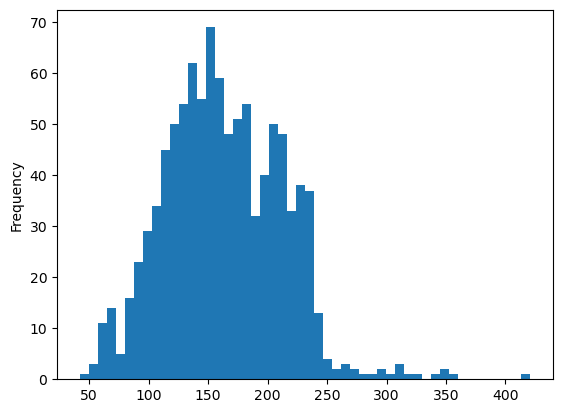

In [8]:
# Description analysis
df['Description'].str.len().plot.hist(bins=50)

In [9]:
df['Genre'] = df['Genre'].str.split(',')

In [59]:
# Label Encoder
from sklearn.preprocessing import MultiLabelBinarizer

multilabel = MultiLabelBinarizer()

labels = multilabel.fit_transform(df['Genre']).astype('float32')

texts = df['Description'].tolist()

print(labels)

[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [46]:
len(labels)

1000

In [31]:
# pytorch and transformers
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from torch.utils.data import Dataset, DataLoader

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification


In [13]:
len(genre_counts)

20

In [14]:
len(labels[0])

20

In [15]:
chekpoint = 'distilbert-base-uncased'
# tokenizer = AutoTokenizer.from_pretrained(chekpoint)
# model = AutoModel.from_pretrained(chekpoint, num_labels=len(genre_counts))

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Tokenize input texts
tokenized_input = tokenizer(texts, truncation=True, padding='max_length', max_length=128)

# Prepare PyTorch dataset
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx][0])
        return item

    def __len__(self):
        return len(self.labels)

In [17]:
train_dataset = CustomDataset(tokenized_input, labels)


In [18]:
train_dataset[0]

{'input_ids': tensor([  101,  1037,  2177,  1997,  6970,  9692, 28804, 12290,  2024,  3140,
          2000,  2147,  2362,  2000,  2644,  1037,  5470, 12070,  2389,  6750,
          2013,  2635,  2491,  1997,  1996,  5304,  1012,   102,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,   

In [41]:
train_data 

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 392702
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9815
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9832
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})

In [19]:
# [x['input_ids'].shape[0] for x in train_dataset]

In [32]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

# Sample data (replace with your own dataset)
# texts = ["This is text 1.", "Another example here.", "More text for the third sample."]
# labels = [[1, 0, 1], [0, 1, 0], [1, 1, 1]]  # Multi-label format

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labels[0]), problem_type='multi_label_classification')

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)


import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, hamming_loss, jaccard_score
from transformers import EvalPrediction
import torch

# Custom multi-label classification loss
def multi_label_loss(output, target):
    return F.binary_cross_entropy_with_logits(output, target.float())

# Training parameters
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

# Training loop
for epoch in range(num_epochs):
    model.train()
    for batch in DataLoader(train_dataset, batch_size=8, shuffle=True):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask).logits

        loss = multi_label_loss(outputs, labels)
        loss.backward()
        optimizer.step()

    # Evaluation
    model.eval()
    val_losses = []
    for batch in DataLoader(val_dataset, batch_size=8):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask).logits

        val_loss = multi_label_loss(outputs, labels)
        val_losses.append(val_loss.item())

    average_val_loss = sum(val_losses) / len(val_losses)
    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {average_val_loss}')

# You can further add evaluation metrics and save the trained model as needed.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Validation Loss: 0.3446393430233002
Epoch 2/3, Validation Loss: 0.3066943979263306
Epoch 3/3, Validation Loss: 0.2780289214849472


In [38]:
# do classification on sample data

model.eval()

# classify on sample data
tokenized_input = tokenizer(["This is text 1.", "Another example here.", "More text for the third sample."], truncation=True, padding='max_length', max_length=128, return_tensors='pt')

outputs = model(**tokenized_input)

# get the prediction
predictions = torch.sigmoid(outputs.logits)

predictions

tensor([[0.2791, 0.3293, 0.1239, 0.1380, 0.3181, 0.2046, 0.5374, 0.1152, 0.1411,
         0.0856, 0.1907, 0.0824, 0.0601, 0.1763, 0.1846, 0.2205, 0.0815, 0.2279,
         0.0822, 0.0778],
        [0.2345, 0.3194, 0.1433, 0.1689, 0.3466, 0.2217, 0.5745, 0.1354, 0.1763,
         0.1114, 0.2108, 0.1100, 0.0784, 0.1989, 0.2410, 0.2184, 0.1047, 0.2502,
         0.1051, 0.0918],
        [0.1864, 0.2165, 0.1034, 0.1324, 0.2885, 0.1936, 0.5940, 0.0862, 0.1231,
         0.0761, 0.1806, 0.0716, 0.0505, 0.1672, 0.2136, 0.1810, 0.0663, 0.2276,
         0.0649, 0.0578]], grad_fn=<SigmoidBackward0>)

In [93]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import Dataset, DataLoader

# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labels[0]), problem_type='multi_label_classification')

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = torch.tensor(self.labels[idx])

        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_len, return_tensors='pt')

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': label
        }

train_dataset = CustomDataset(train_texts, train_labels, tokenizer)
val_dataset = CustomDataset(val_texts, val_labels, tokenizer)


import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, hamming_loss, jaccard_score
from transformers import EvalPrediction
import torch

def multi_labels_metrics(predictions, labels, threshold=0.3):
    # first, apply sigmoid on predictions of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels

    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'macro')
    # accuracy = accuracy_score(y_true, y_pred)
    hamming = hamming_loss(y_true, y_pred)
    # jaccard = jaccard_score(y_true, y_pred, average = 'macro')

    # return as dictionary
    metrics = {'roc_auc': roc_auc,
               'hamming_loss': hamming,
               'f1': f1
               }

    return metrics

def compute_metrics(p: EvalPrediction):
    # If type(p.predictions) = tuple, we take p.predictions[0]; otherwise p.predictions
    preds = p.predictions[0] if isinstance(p.predictions,
            tuple) else p.predictions
    result = multi_labels_metrics(
        predictions=preds,
        labels=p.label_ids)
    return result


# Training arguments
training_args = TrainingArguments(
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    output_dir='./results',
    num_train_epochs=3,
    save_steps=1000,
    save_total_limit=2,
    logging_dir='./logs',
    logging_steps=500,
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Training the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

print(results)

# save model
trainer.save_model("distilbert-finetuned-sem_eval-english-weights")



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/300 [00:00<?, ?it/s]

{'train_runtime': 29.6157, 'train_samples_per_second': 81.038, 'train_steps_per_second': 10.13, 'train_loss': 0.31370747884114586, 'epoch': 3.0}


  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2691498100757599, 'eval_roc_auc': 0.5894200259814462, 'eval_hamming_loss': 0.1145, 'eval_f1': 0.2339616725539116, 'eval_runtime': 0.8932, 'eval_samples_per_second': 223.922, 'eval_steps_per_second': 27.99, 'epoch': 3.0}


In [94]:
trainer.evaluate()

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2691498100757599,
 'eval_roc_auc': 0.5894200259814462,
 'eval_hamming_loss': 0.1145,
 'eval_f1': 0.2339616725539116,
 'eval_runtime': 0.9686,
 'eval_samples_per_second': 206.482,
 'eval_steps_per_second': 25.81,
 'epoch': 3.0}

In [55]:
trainer.evaluate()

  0%|          | 0/25 [00:00<?, ?it/s]

{'eval_loss': 0.2691498100757599,
 'eval_roc_auc': 0.5463089080104132,
 'eval_hamming_loss': 0.10175,
 'eval_f1': 0.12918201095548074,
 'eval_runtime': 0.854,
 'eval_samples_per_second': 234.193,
 'eval_steps_per_second': 29.274,
 'epoch': 3.0}

In [95]:
# Inference
text = "Following clues to the origin of mankind, a team finds a structure on a distant moon, but they soon realize they are not alone."

encoding = tokenizer(text, return_tensors="pt")
encoding.to(trainer.model.device)

outputs = trainer.model(**encoding)

# The logits is a tensor that contains the (unnormalized) scores for every individual label.
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.9234,  0.5812, -2.4778, -2.8435, -1.5859, -2.3758, -1.3815, -2.4439,
         -1.7346, -3.1692, -1.6619, -3.2255, -3.8561, -2.1152, -2.6588, -0.5707,
         -3.2460, -1.6175, -3.3584, -3.2835]], device='cuda:0',
       grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [96]:
# To turn them into actual predicted labels, we first apply a sigmoid function independently to every score, 
# such that every score is turned into a number between 0 and 1, that can be interpreted as a "probability" 
# for how certain the model is that a given class belongs to the input text.

# Next, we use a threshold (typically, 0.5) to turn every probability into either a 1 
# (which means, we predict the label for the given example) or a 0 (which means, we don't predict the label for the given example).

# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(outputs.logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.3)] = 1

# turn predicted id's into actual label names
# predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label > 0]
# print(predicted_labels)


In [97]:
predictions.reshape(1, -1)

array([[1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0.]])

In [98]:
multilabel.classes_

array(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music',
       'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller',
       'War', 'Western'], dtype=object)

In [99]:
multilabel.inverse_transform(predictions.reshape(1, -1))

[('Action', 'Adventure', 'Sci-Fi')]